In [50]:
import random
import math
import csv
import multiprocessing
import re
import seaborn as sns
import scipy   as sc
import pandas  as pd
import numpy   as np

from numpy.linalg            import inv
from scipy.spatial           import cKDTree
from multiprocessing         import Pool
from tqdm                    import tqdm_notebook as tqdm
from matplotlib              import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn                 import preprocessing

# Sarcos 

In [2]:
df = pd.read_csv(open('sarcos_inv.csv'), sep = ',', header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.019478,-0.134218,0.027439,1.516401,0.300936,0.058259,0.150134,-0.266791,-0.237134,-0.091272,...,0.012774,-1.930253,13.439378,-8.935911,14.242047,13.520240,11.695956,1.210212,-22.119289,50.292652
1,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,...,0.017012,-2.211089,11.989628,-7.781117,11.613101,9.550076,14.643369,1.015070,-17.048688,44.104164
2,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,...,0.015857,-2.337160,9.961797,-5.468357,9.550884,5.933340,15.467628,0.910548,-11.415526,37.354858
3,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,...,0.007958,-2.331961,7.332938,-2.434889,7.664916,3.964112,10.309203,0.921360,-5.772058,30.676065
4,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,...,-0.001271,-2.249311,3.797804,0.467865,6.160604,3.175643,2.868096,1.059957,-0.491542,25.920128


In [4]:
df_np = df.values

#x columns
X_cols = df_np[:,:-1]

#y columns
Y_cols = df_np[:,[-1]]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_cols, Y_cols, train_size=100, random_state=101)
X_test = X_test[:50]
y_test = y_test[:50]

In [20]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(50, 21)
(100, 21)
(50, 1)
(100, 1)


In [21]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [22]:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

# MSE Class

In [23]:
#this class will be inherited as a _Base class in the below algorithms 
class _Base():
    
    def mse(self, X, y):
        return np.mean(np.square(self(X) - y))

# Linear Regression Class

In [24]:
def mse(y_hat, y):
    return np.mean(np.square(y_hat - y))

In [25]:
class LinearRegression():
    
    def __init__(self,fit_intercept = True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        
        if self.fit_intercept:
            X = np.insert(X, 0, 1, 1)
            W = np.linalg.inv(X.T @ X) @ X.T @ y
            self.b = W[0]
            self.W = W[1:]
        else:
            self.b = 0
            self.W = np.linalg.inv(X.T @ X) @ X.T @ y
        return self
            
    def __call__(self, X):
        return X @ self.W + self.b
    
model = LinearRegression()
model.fit(X_train, y_train)
y_hatLR = model(X_test)
mse(y_hatLR, y_test)

21.71195382174991

# KNN Class

In [26]:
class kNearestNeighbors(_Base):

    def __init__(self, p = 1, k= 3):
        self.p = p
        self.k = k
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.t = cKDTree(X)
        return self
    
    def __call__(self, X):
        
        #calculate minkowski difference 
        #distance = (np.fabs(X[:,None] - self.X[None,:])**self.p).sum(axis = 2)**(1/self.p)
        
        #identify nn index
        #distance_index  = np.argsort(distance, axis = 1)[:,:self.k]

        #calculate distance, identify indexes and weights
        distance, distance_index  = self.t.query(X, p = self.p, k = self.k)
        distance       = distance.reshape(len(distance), -1)
        distance_index = distance_index.reshape(len(distance), -1)

        weights = (1/distance) / (1/distance).sum(axis = 1, keepdims = True)

        #prediction
        prediction     = np.einsum('ijk,ij->ik', self.y[distance_index], weights)

        return prediction
    
model = kNearestNeighbors()    
model.fit(X_train, y_train)
y_hatKNN = model(X_test)
model.mse(X_test, y_test)

213.51043830436777

## KNN Grid Search

In [27]:
K = range(1, 11)
P = range(1, 6)

MSE = np.empty((len(K), len(P)))

for i, k in tqdm(enumerate(K), total = len(K)):
    for j, p in enumerate(P):
        
        model  = kNearestNeighbors(k = k, p = p)    
        model.fit(X_train, y_train)
        MSE[i,j] = model.mse(X_test, y_test)
        
#np.sort(MSE)

/u/n/jmn43/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


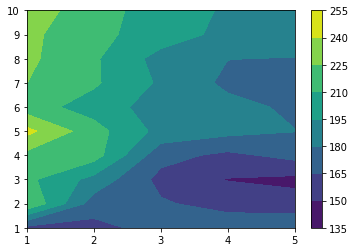

In [28]:
plt.contourf(MSE)
plt.colorbar()

plt.xticks(range(len(P)), labels = P)
plt.yticks(range(len(K)), labels = K)

plt.show()

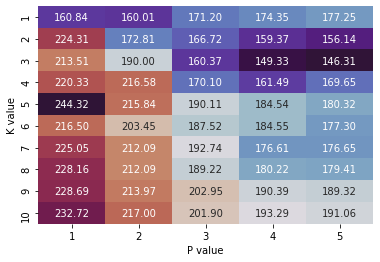

In [29]:
sns.heatmap(MSE, cmap="twilight_shifted", annot = True, cbar = False, fmt = '.2f')

plt.xticks(np.arange(len(P))+ 0.5, labels = P)
plt.yticks(np.arange(len(K))+ 0.5, labels = K)

plt.xlabel("P value")
plt.ylabel("K value")
plt.show()

# Random Forest 

### Decision Tree

In [30]:
#create split for first tree
def find_split(x, y):

    best = {'score' : np.inf}
    for i in range(x.shape[1]):
        for split in np.unique(x[:,i])[:-1]:
            
            right_indices = x[:,i] > split
            left_indices  = x[:,i] <= split
            
            right_var = np.var(y[right_indices]) * (np.sum (right_indices))
            left_var  = np.var(y[left_indices ])  * (np.sum(left_indices ))
            
            score = (right_var + left_var)
            if score < best['score']:
                best = {'feature'       : i,
                        'split'         : split,
                        'score'         : score, 
                        'left_indices'  : left_indices,
                        'right_indices' : right_indices}
    return best

In [31]:
#build a single tree
def build_tree(x, y, max_depth = 5):
    if max_depth == 0 or (y==y[0]).all():
        classes, counts = np.unique(y, return_counts=True)
        return {'leaf' : True, 'class' : classes.mean()}
    
    else:
        move = find_split(x, y)
        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']], max_depth - 1)
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']], max_depth - 1)
        
        return {'leaf'    : False,
                'feature' : move['feature'],
                'split'   : move['split'],
                'score'   : move['score'],
                'left'    : left,
                'right'   : right}

In [32]:
#predict values for one tree
def predict_one(tree, sample):
    """Does the prediction for a single data point"""
    if tree['leaf']:
        return tree['class']
    
    else:
        if sample[tree['feature']] <= tree['split']:
            return predict_one(tree['left'], sample)
        else:
            return predict_one(tree['right'], sample)

def predict(tree, X):
    return np.array(list(map(lambda x : predict_one(tree, x), X)))

### Random Forest Prediction

In [34]:
# Create a random subsample from the dataset with replacement
empty =[]
def subsample(N, n, m, pn, pm):
    # n - number of rows
    # m - number of cols
    # N - number of trees
    pn = int(n * pn)
    pm = int(m * pm)
    for i in range(N):
        rows = np.random.choice(n, size = pn, replace = True )
        cols = np.random.choice(m, size = pm, replace = False) 
        empty.append(cols)
        yield rows, cols
        
rows, cols = [], []

for row, col in subsample(10, *X_train.shape, 1.2, 1.0):
    rows.append(row)
    cols.append(col)

In [42]:
# %%time
forest = []
def forest_func(X):
    for row, col in subsample((10), *X_train.shape, 1.2, 1.0):
        #print(row, col, sep = '\n', end = '\n\n')
        forest.append(build_tree(X_train[row][:,col], X_train[row]))

def _build_tree(i):
    return build_tree(X_train[rows[i]][:,cols[i]], y_train[rows[i]])

with Pool(32) as p:
    forest = p.map(_build_tree, range(10))

In [43]:
def predict_forest(forest, X):
    return np.array([predict(tree, X[:,col]) for tree, col in zip(forest, empty)]).T.mean\
            (axis = 1, keepdims = True)

In [44]:
def mse(y_hat, y):
    return np.mean(np.square(y_hat - y))

In [45]:
y_hat = predict_forest(forest, X_test)

In [46]:
mse(y_hat, y_test)

123.37859147207683

# Gaussian Process Class

In [47]:
class LinearRegression():
    
    def __init__(self,fit_intercept = True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        
        if self.fit_intercept:
            X = np.insert(X, 0, 1, 1)
            W = np.linalg.inv(X.T @ X) @ X.T @ y
            self.b = W[0]
            self.W = W[1:]
        else:
            self.b = 0
            self.W = np.linalg.inv(X.T @ X) @ X.T @ y
        return self
            
    def __call__(self, X):
        return X @ self.W + self.b
    
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat = lr(X_train)
residuals = y_train - y_hat

In [48]:
class _GPBase():
    
    def SE_kernel(self, x1, x2, l, s):
        x1 = x1 / l
        x2 = x2 / l
    
        self.dist = np.square(x1[:,None] - x2[None,:]).sum(axis =-1) 
        kernel    = s * np.exp(-self.dist)
    
        return kernel
    
    def cost_function(self, n, y, Ks, sigma, L): # Ks := K + noise
        
        ret = -(1 / 2) * (np.log(2 * np.pi) * n + 
                          np.prod(np.linalg.slogdet(Ks)) +
                          np.trace(y.T.dot(self.K_inv.dot(y))))
        
        return ret
    
    def SE_kernel_gradients(self, sigma, y, n, K, l, s, s2):
        
        # prior hyperparameters
        c        = 10
        prior_l  = np.log(l)
        prior_s  = np.log(s)
        prior_s2 = np.log(s2)
        
        #hyperparameter differentials
        d_s2     = sigma * np.eye(n)
        d_l      = self.dist * K
        d_s      = K

        # sigma gradient 
        g_s2  = - 1 / 2 * (np.trace(self.K_inv @ d_s2) - np.trace(y.T @ self.K_inv @ d_s2 @ self.K_inv @ y))\
                - (c * prior_s2)
        
        # l gradient 
        g_l   = - 1 / 2 * (np.trace(self.K_inv @ d_l ) - np.trace(y.T @ self.K_inv @ d_l  @ self.K_inv @ y))\
                - (c * prior_l)

        # s gradient 
        g_s   = - 1 / 2 * (np.trace(self.K_inv @ d_s ) - np.trace(y.T @ self.K_inv @ d_s  @ self.K_inv @ y))\
                - (c * prior_s)
        
        return g_l, g_s, g_s2

/u/n/jmn43/python/lib/python3.6/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


2.40 1.20 1.58 -158.83        


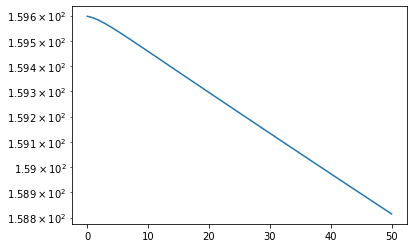

20.759329829282045

In [49]:
class GaussianProcess(_Base, _GPBase):
    
    def __init__(self, mu_func = LinearRegression):
        self.mu_func = mu_func
    
    def fit(self, X, y, alpha, epochs):
        
        self.f   = self.mu_func().fit(X, y)
        y        = y - self.f(X)
        self.std = y.std()
        y        = y / self.std
        self.X   = X.copy()
        self.y   = y.copy()

        np.random.seed(0)
        
        logl   = np.random.normal(scale = 0.5)
        logs   = np.random.normal(scale = 0.5)
        logs2  = np.random.normal(scale = 0.5)
        
        n      = len(X)
        I      = np.eye(n)
        
        self.L = np.empty(epochs + 1)
        g_l, g_s, g_s2 = 0, 0, 0
        momentum = 0.6
        
        for i in tqdm(range(epochs), desc = 'GP'):
            l, s, s2    = np.exp([logl, logs, logs2])
            K           = self.SE_kernel(X, X, l, s)
            Ks          = K + s2 * I
            L           = np.linalg.cholesky(Ks)
            self.K_inv  = sc.linalg.cho_solve((L, True), I)
            self.L[i]   = self.cost_function(n, y, Ks, s2, L)
            
            print('\r' + ' ' * 30, end = '')
            print(f'\r{l:.2f} {s:.2f} {s2:.2f} {self.L[i]:.2f}', end = '')
            
            gg_l, gg_s, gg_s2 = self.SE_kernel_gradients(s2, y, n, K, l, s, s2)
            
            g_l   *= momentum
            g_s   *= momentum
            g_s2  *= momentum
             
            g_l   += gg_l
            g_s   += gg_s
            g_s2  += gg_s2
                
            logs2 += (g_s2 * alpha)
            logs  += (g_s * alpha)
            logl  += (g_l * alpha)
        
        l, s, s2     = np.exp([logl, logs, logs2])
        K            = self.SE_kernel(X, X, l, s)
        Ks           = K + s2 * I
        L            = np.linalg.cholesky(Ks)

        self.K_inv   = sc.linalg.cho_solve((L, True), I)    
        self.L[-1]   = self.cost_function(n, y, Ks, s2, L)
        self.l       = l
        self.s       = s
        self.s2      = s2
        self.params  = l, s, s2
        
        return self
    
    def __call__(self, X, batch = 128):
        
        mu  = lambda X: self.SE_kernel(X, self.X, self.l, self.s).dot(self.K_inv).dot(self.y) * self.std +\
                        self.f(X)
        
        return np.concatenate([mu(X[i * batch: (i + 1) * batch]) for i in range(len(X) // batch + 1)], axis = 0)
    
model = GaussianProcess()
y_hatGP = model.fit(X_train, y_train, 1e-5, 50)
plt.semilogy(-model.L)
plt.show()
model.mse(X_test, y_test)
